In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

# Example-01: Twiss from amplitude data

In [3]:
# In this example twiss beta values are estimated from amplitude data
# Signals are generated using exact model with random noise added on top
# In this case result error is due to the noise alone

# Given the TbT data, the main frequency and correcponding parameters (amplitude and phase) are estimated for x & y planes
# Amplitude data is used to estimate twiss beta values
# Model beta values are used to estimate action at each monitor location
# Total action is estimated using actions from all monitors with optional outlier filtering

In [4]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [5]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.536883161, sigma_nux=6.79394229e-07, error_nux=6.2197137e-08

(ax - ref_ax).abs().sum().item()=9.17113528e-05

(fx - ref_fx).abs().sum().item()=0.0316235269



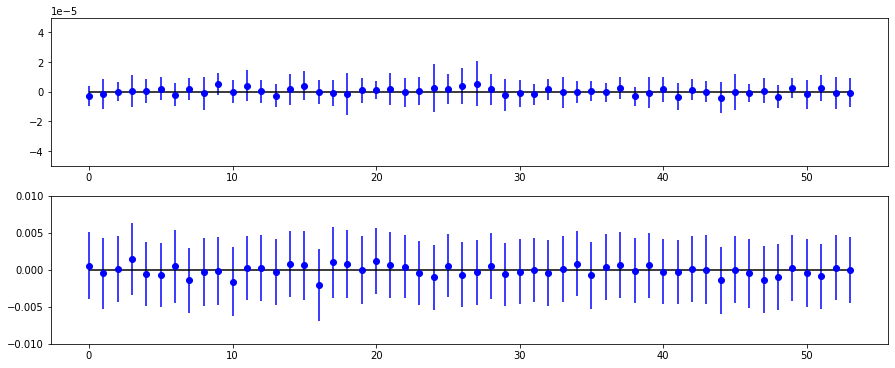

In [6]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy= 0.576774571, sigma_nuy=1.0169659e-06, error_nuy=6.24399834e-08

(ay - ref_ay).abs().sum().item()=9.77416925e-05

(fy - ref_fy).abs().sum().item()=0.0486191657



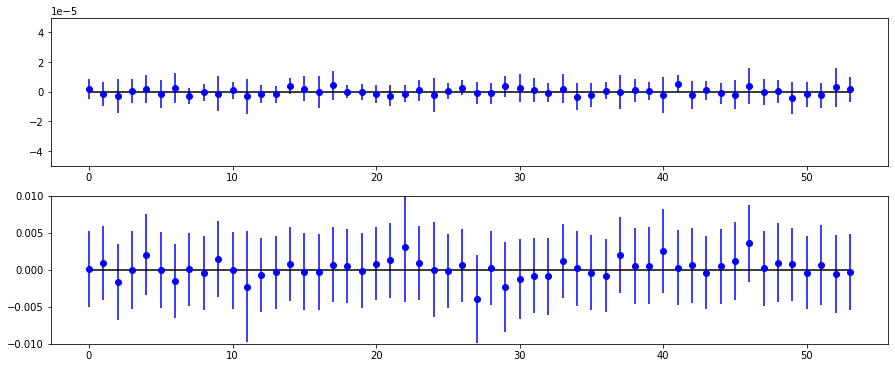

In [7]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

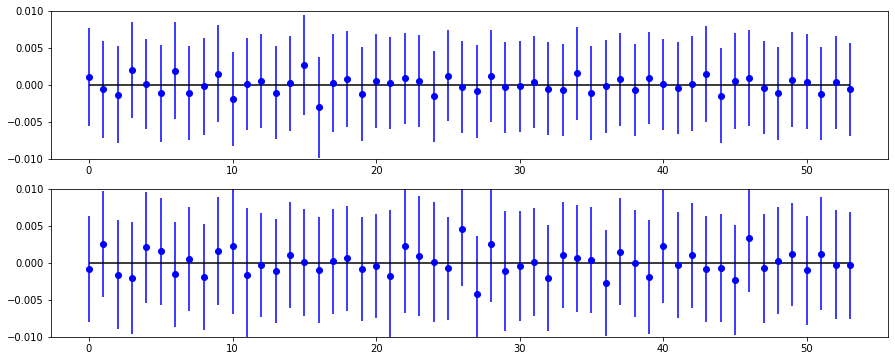

In [8]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [9]:
# Set twiss instance

twiss = Twiss(model, table, use_model=False)

dict_keys(['jx', 'sigma_jx', 'center_jx', 'spread_jx', 'jy', 'sigma_jy', 'center_jy', 'spread_jy', 'mask'])

(abs(ref_jx - center_jx)/ref_jx).item() = 0.000301683616
(abs(ref_jy - center_jy)/ref_jy).item() = 0.000208189908



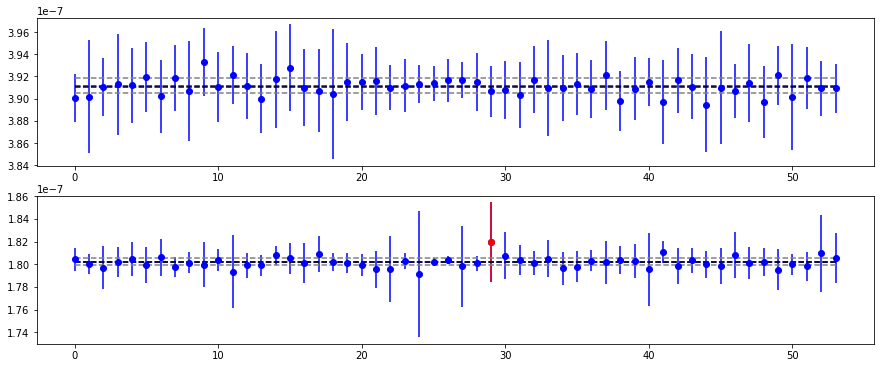

In [10]:
# Estimate action

twiss.get_action(data_threshold={'use': True, 'factor': 3.0})
print(twiss.action.keys())
print()

jx, sigma_jx, center_jx, spread_jx = twiss.action['jx'], twiss.action['sigma_jx'], twiss.action['center_jx'], twiss.action['spread_jx']
jy, sigma_jy, center_jy, spread_jy = twiss.action['jy'], twiss.action['sigma_jy'], twiss.action['center_jy'], twiss.action['spread_jy']

ref_jx = (ref_ax**2/(2.0*model.bx[model.monitor_index])).mean()
ref_jy = (ref_ay**2/(2.0*model.by[model.monitor_index])).mean()

print(f'{(abs(ref_jx - center_jx)/ref_jx).item() = :12.9}')
print(f'{(abs(ref_jy - center_jy)/ref_jy).item() = :12.9}')
print()

mask_x, mask_y = twiss.action['mask'].logical_not()
out_jx, out_jy = torch.arange(model.monitor_count)[mask_x], torch.arange(model.monitor_count)[mask_y]

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), jx.cpu().numpy(), yerr=sigma_jx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.errorbar(out_jx.cpu().numpy(), jx[out_jx].cpu().numpy(), yerr=sigma_jx[out_jx].cpu().numpy(), fmt=' ', marker='o', color='red')
ax1.hlines([(center_jx - spread_jx).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax1.hlines([center_jx.cpu().numpy()], 0, model.monitor_count - 1, colors='blue', linestyles='dashed')
ax1.hlines([(center_jx + spread_jx).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax1.hlines([ref_jx.cpu().numpy()], 0, model.monitor_count - 1, colors='black', linestyles='dashed')


ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), jy.cpu().numpy(), yerr=sigma_jy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.errorbar(out_jy.cpu().numpy(), jy[out_jy].cpu().numpy(), yerr=sigma_jy[out_jy].cpu().numpy(), fmt=' ', marker='o', color='red')
ax2.hlines([(center_jy - spread_jy).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax2.hlines([center_jy.cpu().numpy()], 0, model.monitor_count - 1, colors='blue', linestyles='dashed')
ax2.hlines([(center_jy + spread_jy).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax2.hlines([ref_jy.cpu().numpy()], 0, model.monitor_count - 1, colors='black', linestyles='dashed')

plt.show()

dict_keys(['bx', 'sigma_bx', 'by', 'sigma_by'])

(bx - model.bx[model.monitor_index]).abs().sum().item()= 0.605464543
(by - model.by[model.monitor_index]).abs().sum().item()=  1.14627166



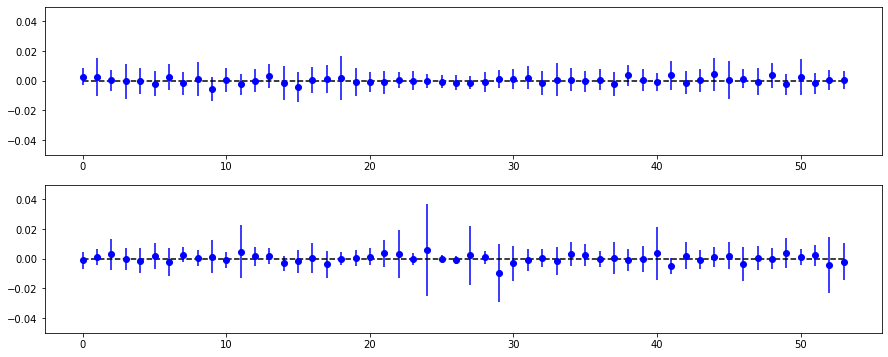

In [11]:
# Estimate twiss beta

twiss.get_twiss_from_amplitude()
print(twiss.data_amplitude.keys())
print()

bx, sigma_bx = twiss.data_amplitude['bx'], twiss.data_amplitude['sigma_bx']
by, sigma_by = twiss.data_amplitude['by'], twiss.data_amplitude['sigma_by']

bx_m = model.bx[model.monitor_index]
by_m = model.by[model.monitor_index]

print(f'{(bx - model.bx[model.monitor_index]).abs().sum().item()=:12.9}')
print(f'{(by - model.by[model.monitor_index]).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), ((bx_m - bx)/bx_m).cpu().numpy(), yerr=(sigma_bx/bx_m).cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black', linestyles='dashed')
ax1.set_ylim(-0.05, +0.05)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), ((by_m - by)/by_m).cpu().numpy(), yerr=(sigma_by/by_m).cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black', linestyles='dashed')
ax2.set_ylim(-0.05, +0.05)

plt.show()

In [12]:
# Twiss beta values and errors can be passed to get_action()
# Data at monitor locations should be passed

twiss.get_action()
print([twiss.action['center_jx'].item(), twiss.action['center_jy'].item()])
print([twiss.action['spread_jx'].item(), twiss.action['spread_jy'].item()])

twiss.get_action(bx=model.bx[model.monitor_index], by=model.by[model.monitor_index], sigma_bx=model.sigma_bx[model.monitor_index], sigma_by=model.sigma_by[model.monitor_index])
print([twiss.action['center_jx'].item(), twiss.action['center_jy'].item()])
print([twiss.action['spread_jx'].item(), twiss.action['spread_jy'].item()])

[3.9118004483872746e-07, 1.8021655307979926e-07]
[6.787649547750154e-10, 3.039939435349848e-10]
[3.9118004483872746e-07, 1.8021655307979926e-07]
[6.787649547750154e-10, 3.039939435349848e-10]


# Example-02: Virtual phase and phase correction

In [13]:
# TbT data is only avalible at monitor locations
# Phase at other locations of interest (virtual locations) can be estimated using measured phase at monitors and model advance between them
# For each virtual location, monitor locations around it are used to estimate virtual phase
# Given range limit, the corresponding number of monitors are used on each side around the probed virtual location

# Similary, monitor location itself can be treated as a virtual location, i.e. data from other locations can be used to impove estimation at selected probed location
# Strong bias towards model is introduced in this case, i.e. phase correction should be avoided if real lattice is not close to the model
# Phase at the probed monitor is not used, but can be added or compared with measured phase

# In both cases, the range limit is passed to the method

In [14]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [15]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux=  0.53688298, sigma_nux=6.63313599e-07, error_nux=1.19064074e-07

(ax - ref_ax).abs().sum().item()=0.000106343516

(fx - ref_fx).abs().sum().item()=0.0457380486



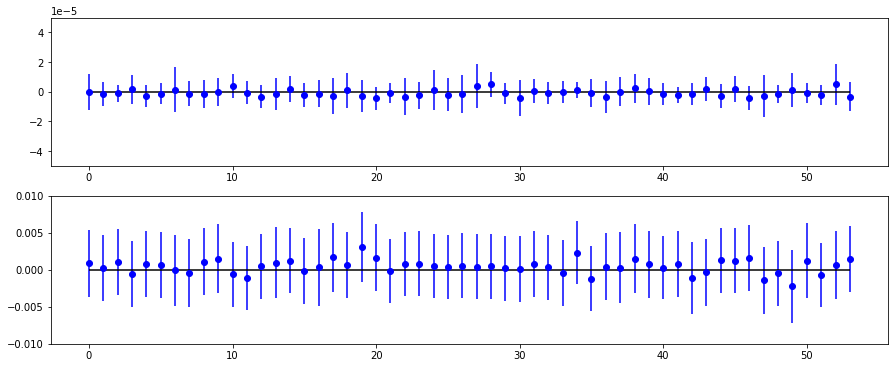

In [16]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy= 0.576774464, sigma_nuy=7.98655507e-07, error_nuy=1.69306166e-07

(ay - ref_ay).abs().sum().item()=0.000108082816

(fy - ref_fy).abs().sum().item()=0.0406145348



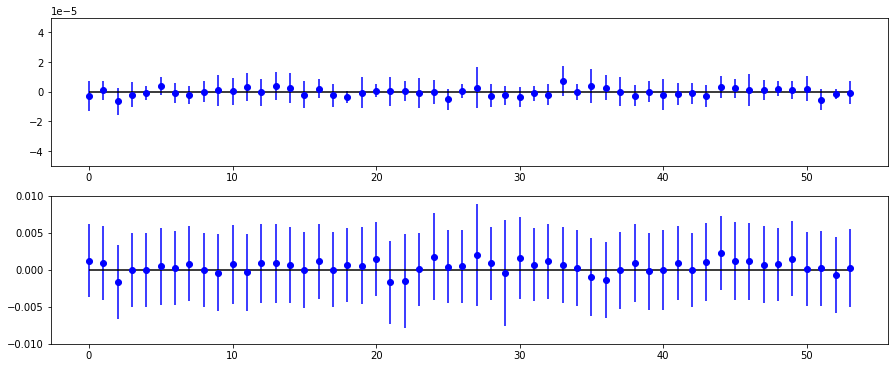

In [17]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

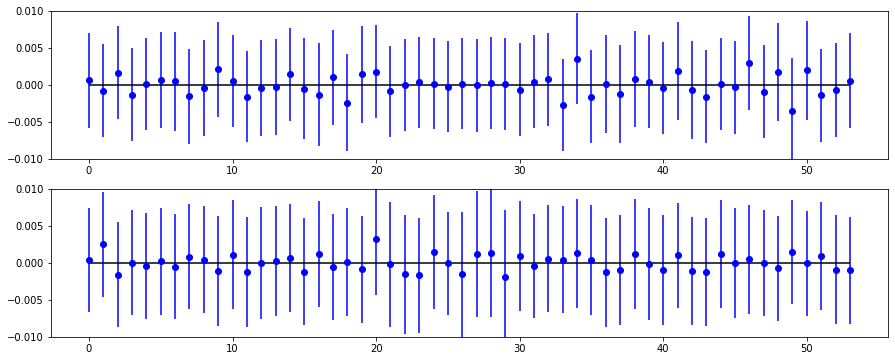

In [18]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [19]:
# Set twiss instance

twiss = Twiss(model, table)

In [20]:
# Print total number of virtual locations and corresponding index
# Note, the first and the last are special virtual locations ('HEAD' and 'TAIL')

print(twiss.model.virtual_count)
print(twiss.model.virtual_index)

# Compute virtual phase at each virtual location
# twiss.fx, twiss.fy and corresponding error are updated (zero at initialization at virtual location indices)
# twiss.correct_x and twiss.correct_y dictionaries with additional information are created or updated
# Note, kwargs can be passed to Decomposition.phase_virtual()

twiss.phase_virtual(limit=8, clean=True, factor=2.0)

5
[0, 2, 28, 54, 58]


dict_keys(['model', 'probe', 'limit', 'index', 'clean', 'phase', 'error'])
tensor([1.020885616636e+00, 3.504198899203e-04], dtype=torch.float64)
28
8
{20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36}
tensor([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


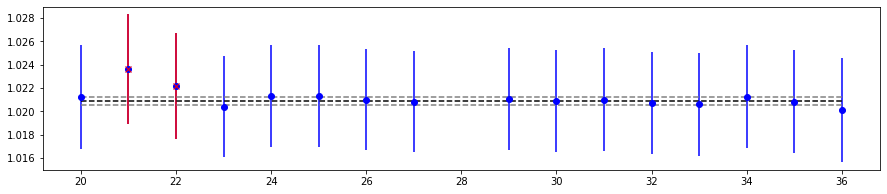

In [21]:
# Examine additional data for a virtual location at IP

_, _, index, *_ = twiss.model.virtual_index

# For each virtual location, addition data dictionary is stored

print(twiss.virtual_x[index].keys())

# Estimated value & error

print(twiss.virtual_x[index]['model'])

# Virtual location index

print(twiss.virtual_x[index]['probe'])

# Range limit

print(twiss.virtual_x[index]['limit'])

# Used locations {index: location}

print(twiss.virtual_x[index]['index'])

# Filter mask

print(twiss.virtual_x[index]['clean'].to(torch.int64))

# Plot phase data and error

keys = torch.tensor([*twiss.virtual_x[index]['index'].keys()], dtype=torch.int64)
mask = twiss.virtual_x[index]['clean'].logical_not()

center, spread = twiss.virtual_x[index]['model'].cpu().numpy()

plt.figure(figsize=(15, 3))
plt.errorbar(keys, twiss.virtual_x[index]['phase'].cpu().numpy(), yerr=twiss.virtual_x[index]['error'].cpu().numpy(), fmt=' ', color='blue', marker='o')
plt.errorbar(keys[mask], twiss.virtual_x[index]['phase'][mask].cpu().numpy(), yerr=twiss.virtual_x[index]['error'][mask].cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines([center - spread, center, center + spread], min(keys), max(keys), color=['grey', 'black', 'grey'], linestyles='dashed')
plt.show()

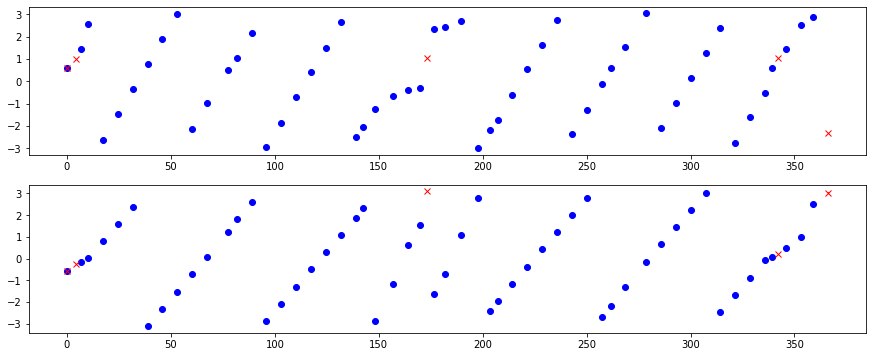

In [22]:
# Plot x & y phase for all locations vs location position

# blue -- monitor locations
# red  -- virtual locations

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.fx[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_fx[model.monitor_index].cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.errorbar(model.time[model.virtual_index].cpu().numpy(), twiss.fx[model.virtual_index].cpu().numpy(), yerr=twiss.sigma_fx[model.virtual_index].cpu().numpy(), fmt=' ', marker='x', color='red')

ax2 = plt.subplot(212)
ax2.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.fy[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_fy[model.monitor_index].cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.errorbar(model.time[model.virtual_index].cpu().numpy(), twiss.fy[model.virtual_index].cpu().numpy(), yerr=twiss.sigma_fy[model.virtual_index].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

In [23]:
# Perform phase correction
# Note, kwargs are passed to Decomposition.phase_virtual()

# Similar to virtual phase computation, twiss.correct_x & twiss.correct_y dictionaries are created or updated
# twiss.fx_correct, twiss.fy_correct attributes and corresponding errors are created

twiss.phase_correct(limit=8, clean=True, factor=2.0)

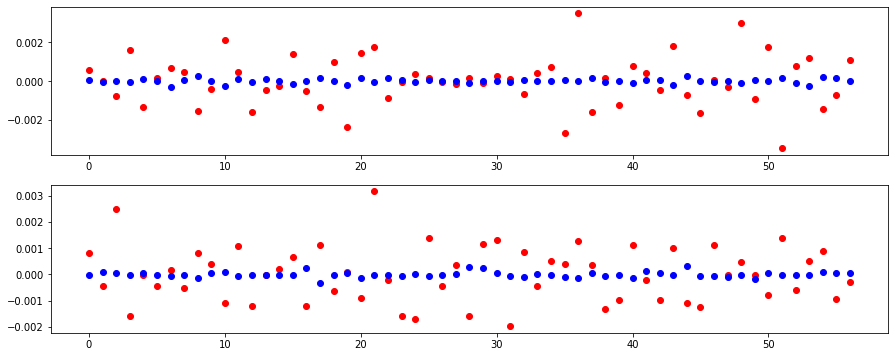

(mux - twiss.model.phase_x)[1:-1].abs().sum().item()=0.0563475532
(muy - twiss.model.phase_y)[1:-1].abs().sum().item()=0.0495483532

(mux_correct - twiss.model.phase_x)[1:-1].abs().sum().item()=0.00477051116
(muy_correct - twiss.model.phase_y)[1:-1].abs().sum().item()=0.00421849611



In [24]:
# Compare adjacent phase advance for uncorrected and corrected case vs model (endpoints are dropped)

# Uncorrected

mux, _ = Decomposition.phase_adjacent(twiss.table.nux, twiss.fx)
muy, _ = Decomposition.phase_adjacent(twiss.table.nuy, twiss.fy)

# Corrected

mux_correct, _ = Decomposition.phase_adjacent(twiss.table.nux, twiss.fx_correct)
muy_correct, _ = Decomposition.phase_adjacent(twiss.table.nuy, twiss.fy_correct)

# Plot

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_x - mux)[1:-1].cpu().numpy(), color='red', marker='o')
ax1.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_x - mux_correct)[1:-1].cpu().numpy(), color='blue', marker='o')

ax2 = plt.subplot(212)
ax2.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_y - muy)[1:-1].cpu().numpy(), color='red', marker='o')
ax2.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_y - muy_correct)[1:-1].cpu().numpy(), color='blue', marker='o')

plt.show()

print(f'{(mux - twiss.model.phase_x)[1:-1].abs().sum().item()=:12.9}')
print(f'{(muy - twiss.model.phase_y)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(mux_correct - twiss.model.phase_x)[1:-1].abs().sum().item()=:12.9}')
print(f'{(muy_correct - twiss.model.phase_y)[1:-1].abs().sum().item()=:12.9}')
print()

# Example-03: Twiss from phase data (adjacent)

In [25]:
# In this example, twiss parameters are computed from phase data using only adjacent monitors, i.e. range limit is one
# Results are compared with model
# Twiss beta values are also compared with twiss from amplitude data computation

In [26]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [27]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.536883076, sigma_nux=7.47949819e-07, error_nux=2.24963865e-08

(ax - ref_ax).abs().sum().item()=0.000111992713

(fx - ref_fx).abs().sum().item()=0.0294315415



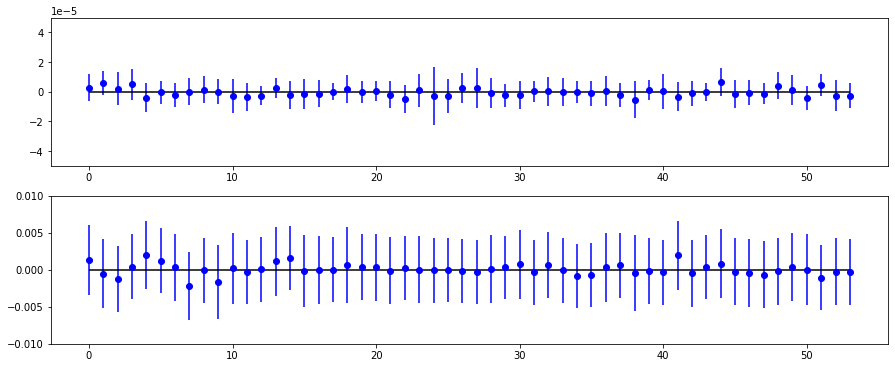

In [28]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy= 0.576774562, sigma_nuy=7.41981779e-07, error_nuy=7.0979696e-08

(ay - ref_ay).abs().sum().item()=0.00010665116

(fy - ref_fy).abs().sum().item()=0.0414636509



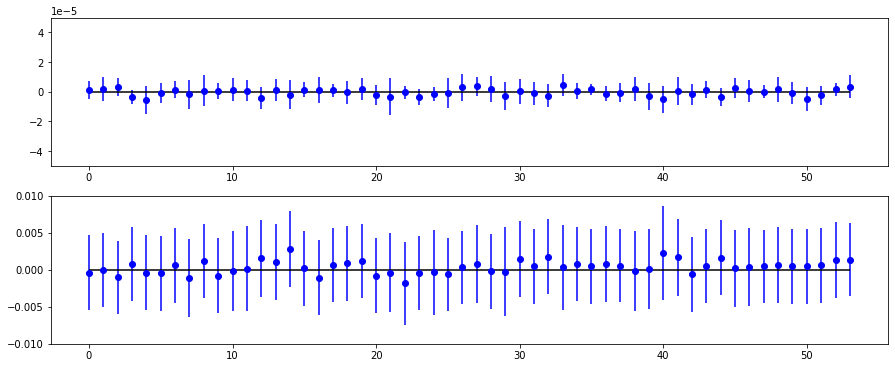

In [29]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

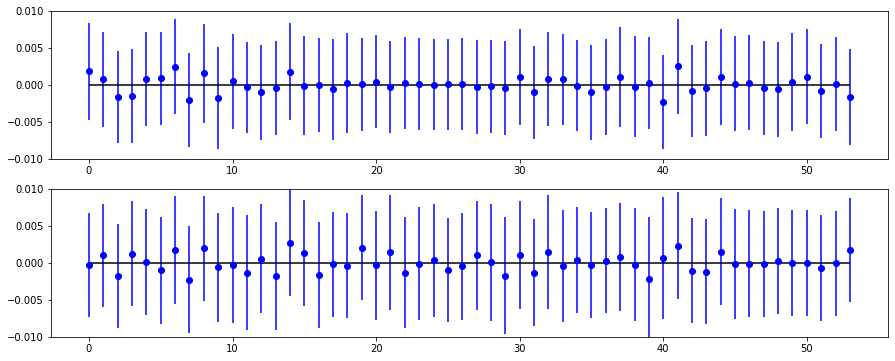

In [30]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [31]:
# Set twiss instance

twiss = Twiss(model, table, limit=1)

# Estimate twiss from amplitude data

twiss.get_action()
twiss.get_twiss_from_amplitude()

# Estimate twiss from phase data
# Note, virtual locations are not used as other for given probe

twiss.phase_virtual()
twiss.get_twiss_from_phase()

In [32]:
# Invocation of get_twiss_from_phase sets twiss.data_phase dictionary
# This dictionary contains model and estimated results for each triplet (phase advance, twiss parameters and corresponding errors)

for key in twiss.data_phase:
    print(key)
    
# i -- probed index, j & k -- other used indices, each combination is given by two pairs (i, j) & (i, k), phase advance is always from i and is negative if i is behind j or k timewise

# fx_ij, fx_m_ij -- estimated and model phase advance for i to j or k for x plane and corresponding errors with 'sigma' prefix
# fy_ij, fy_m_ij -- estimated and model phase advance for i to j or k for y plane and corresponding errors with 'sigma' prefix

# ax, bx -- estimated twiss parameters and corresponding error for x plane and corresponding errors with 'sigma' prefix
# ay, by -- estimated twiss parameters and corresponding error for y plane and corresponding errors with 'sigma' prefix

fx_ij
sigma_fx_ij
fx_m_ij
sigma_fx_m_ij
fx_ik
sigma_fx_ik
fx_m_ik
sigma_fx_m_ik
fy_ij
sigma_fy_ij
fy_m_ij
sigma_fy_m_ij
fy_ik
sigma_fy_ik
fy_m_ik
sigma_fy_m_ik
ax
sigma_ax
bx
sigma_bx
ay
sigma_ay
by
sigma_by


In [33]:
# Since range limit is one here, each location has only one computed value

print(twiss.data_phase['bx'].shape)

torch.Size([59, 1])


In [34]:
# Note, here 'HEAD' virtual location is at the same place as the 1st monitor location
# Phase advance in this case is zero and twiss parameters are not meaningful for 'HEAD' virtual location

print(model.is_same(0, 1))

True


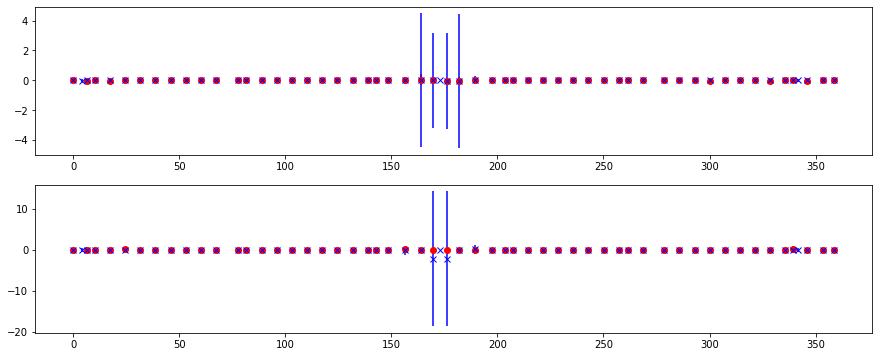

(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()=  0.71552623
(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=  1.30803423

(bx_m - bx_f)[1:-1].abs().sum().item()=  0.49176249
(by_m - by_f)[1:-1].abs().sum().item()=  5.36501989



In [35]:
# Plot twiss beta results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

bx_m, by_m = twiss.model.bx, twiss.model.by

# Twiss from amplitude

bx_a, sigma_bx_a = twiss.data_amplitude['bx'], twiss.data_amplitude['sigma_bx']
by_a, sigma_by_a = twiss.data_amplitude['by'], twiss.data_amplitude['sigma_by']

# Twiss from phase

bx_f, sigma_bx_f = twiss.data_phase['bx'].flatten(), twiss.data_phase['sigma_bx'].flatten()
by_f, sigma_by_f = twiss.data_phase['by'].flatten(), twiss.data_phase['sigma_by'].flatten()

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m[twiss.model.monitor_index] - bx_a).cpu().numpy(), yerr=sigma_bx_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (bx_m - bx_f)[1:-1].cpu().numpy(), yerr=sigma_bx_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m[twiss.model.monitor_index] - by_a).cpu().numpy(), yerr=sigma_by_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (by_m - by_f)[1:-1].cpu().numpy(), yerr=sigma_by_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

plt.show()

print(f'{(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()=:12.9}')
print(f'{(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f)[1:-1].abs().sum().item()=:12.9}')
print()

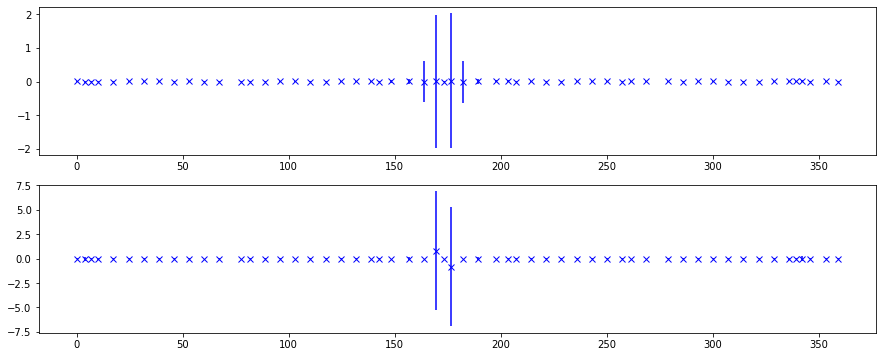

(ax_m - ax_f)[1:-1].abs().sum().item()= 0.129274568
(ay_m - ay_f)[1:-1].abs().sum().item()=   1.7836858



In [36]:
# Plot twiss alpha results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

ax_m, ay_m = twiss.model.ax, twiss.model.ay

# Twiss from phase

ax_f, sigma_ax_f = twiss.data_phase['ax'].flatten(), twiss.data_phase['sigma_ax'].flatten()
ay_f, sigma_ay_f = twiss.data_phase['ay'].flatten(), twiss.data_phase['sigma_ay'].flatten()

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ax_m - ax_f)[1:-1].cpu().numpy(), yerr=sigma_ax_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ay_m - ay_f)[1:-1].cpu().numpy(), yerr=sigma_ay_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

plt.show()

print(f'{(ax_m - ax_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f)[1:-1].abs().sum().item()=:12.9}')
print()

# Example-04: Twiss from phase data (range limit & phase correction)

In [37]:
# In this example several combinations (triplets = two diffrent pairs that include probe and two other) are used to estimate twiss parameters for given probed location
# For each combination twiss parameters and corresponding errors are computed
# Data from different combinations can be filtered (remove outlires) and processed (center and spread estimation)

# Twiss parameters are also computed using corrected phase
# Note, phase correction generates strong bias towards the used model
# In this example signals are generated using exact model and this bias is not manifested

In [38]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [39]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.536883084, sigma_nux=7.6537686e-07, error_nux=1.46140755e-08

(ax - ref_ax).abs().sum().item()=0.000115582104

(fx - ref_fx).abs().sum().item()=0.0363671978



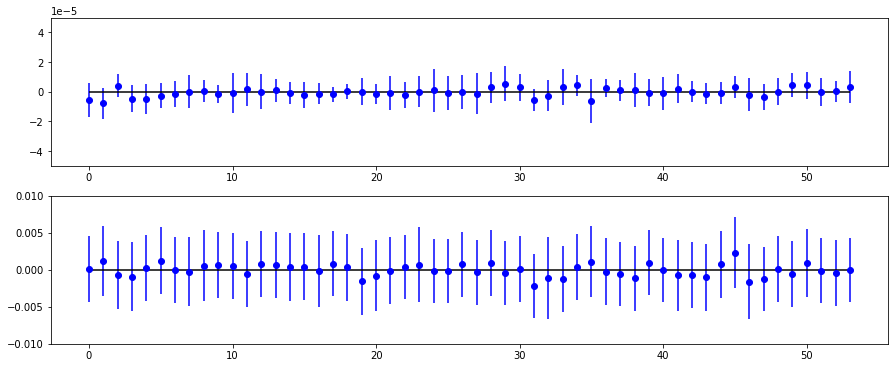

In [40]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy= 0.576774965, sigma_nuy=9.65958373e-07, error_nuy=3.31398493e-07

(ay - ref_ay).abs().sum().item()=9.84685746e-05

(fy - ref_fy).abs().sum().item()=0.0717594397



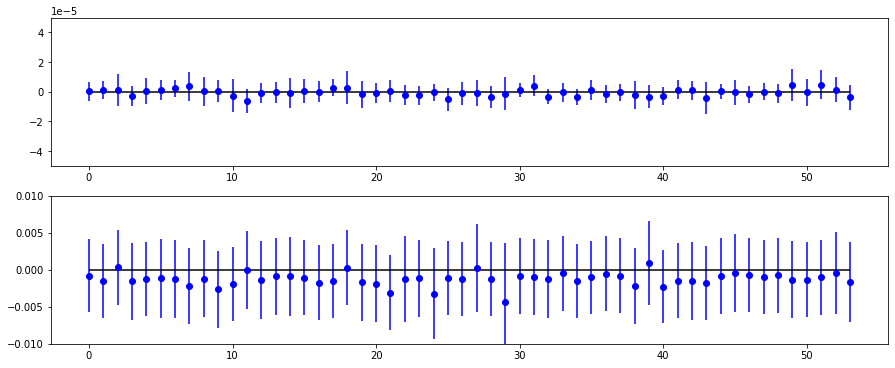

In [41]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

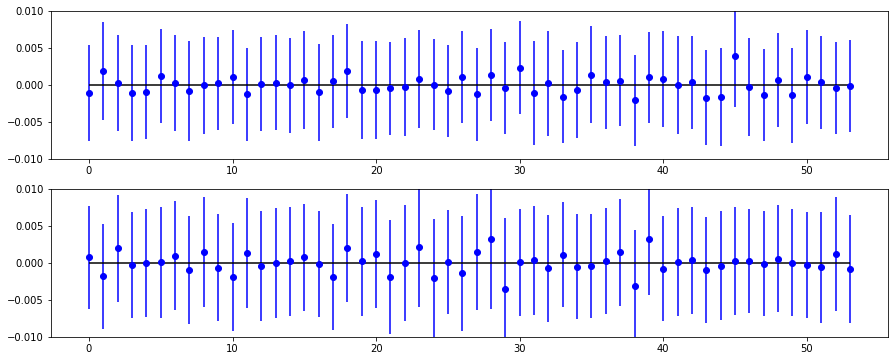

In [42]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [43]:
# Estimate twiss parameters using adjacent monitors
# For each probed location the closest monitor location is used on each side

# Set twiss instance

twiss = Twiss(model, table, limit=1)

# Estimate twiss from amplitude data

twiss.get_action()
twiss.get_twiss_from_amplitude()

# Estimate twiss from phase data
# Note, virtual locations are not used as other for given probe

twiss.phase_virtual()
twiss.get_twiss_from_phase()

# Twiss from amplitude

bx_a, sigma_bx_a = twiss.data_amplitude['bx'], twiss.data_amplitude['sigma_bx']
by_a, sigma_by_a = twiss.data_amplitude['by'], twiss.data_amplitude['sigma_by']

# Twiss from phase

bx_f, sigma_bx_f = twiss.data_phase['bx'].flatten(), twiss.data_phase['sigma_bx'].flatten()
by_f, sigma_by_f = twiss.data_phase['by'].flatten(), twiss.data_phase['sigma_by'].flatten()

ax_f, sigma_ax_f = twiss.data_phase['ax'].flatten(), twiss.data_phase['sigma_ax'].flatten()
ay_f, sigma_ay_f = twiss.data_phase['ay'].flatten(), twiss.data_phase['sigma_ay'].flatten()

In [44]:
# Estimate using range of monitors
# Here, for each probed location 8 monitor locations are used on each side

twiss = Twiss(model, table, limit=8)
twiss.phase_virtual()
twiss.get_twiss_from_phase()

In [45]:
# Note, for given range limit, the number of combinations is limit*(2*limit - 1)

print(max(twiss.limit))
print(max(twiss.limit)*(2*max(twiss.limit) - 1))
print(twiss.data_phase['bx'].shape)

8
120
torch.Size([59, 120])


In [46]:
# Pairs are also generated for each location
# Note, virtual locations do not appear as other indices
# Combinations are also sorted by limit

print(twiss.combo[0].shape)
print(twiss.combo[0, 0].cpu().numpy().tolist())
# [[i, j], [i, k]]

torch.Size([120, 2, 2])
[[0, -2], [0, 1]]


In [47]:
# Data filtering can be performed with filter_twiss method (filtering is performed for x or y plane at a time)
# This method returns a mask with True/False values, True if a combination passes all filtering methods and False otherwise
# This mask can be used as weights, i.e. combinations with False have zero weight

# Several filtering options are avaliable (by default all are used)
# Set 'use' value to True or False

mask_x = twiss.filter_twiss(plane='x',
                            phase={'use': True, 'threshold': 10.0},
                            model={'use': True, 'threshold': 0.5},
                            value={'use': True, 'threshold': 0.5},
                            sigma={'use': True, 'threshold': 0.25},
                            limit={'use': True, 'threshold': 5.0},
                           )

mask_y = twiss.filter_twiss(plane='y',
                            phase={'use': True, 'threshold': 10.0},
                            model={'use': True, 'threshold': 0.5},
                            value={'use': True, 'threshold': 0.5},
                            sigma={'use': True, 'threshold': 0.25},
                            limit={'use': True, 'threshold': 5.0},
                           )

# phase -- clean based on absolute cotangents value for (i, j) or (i, k) model and measured advance
# model -- clean based on advance proximity to model
# value -- clean based on beta proximity to model
# sigma -- clean based on estimated phase advance error value
# limit -- clean outliers outside interval computed using robust center and spread estimators

print(len(mask_x.flatten()), mask_x.count_nonzero().item())
print(len(mask_y.flatten()), mask_y.count_nonzero().item())

7080 6432
7080 5957


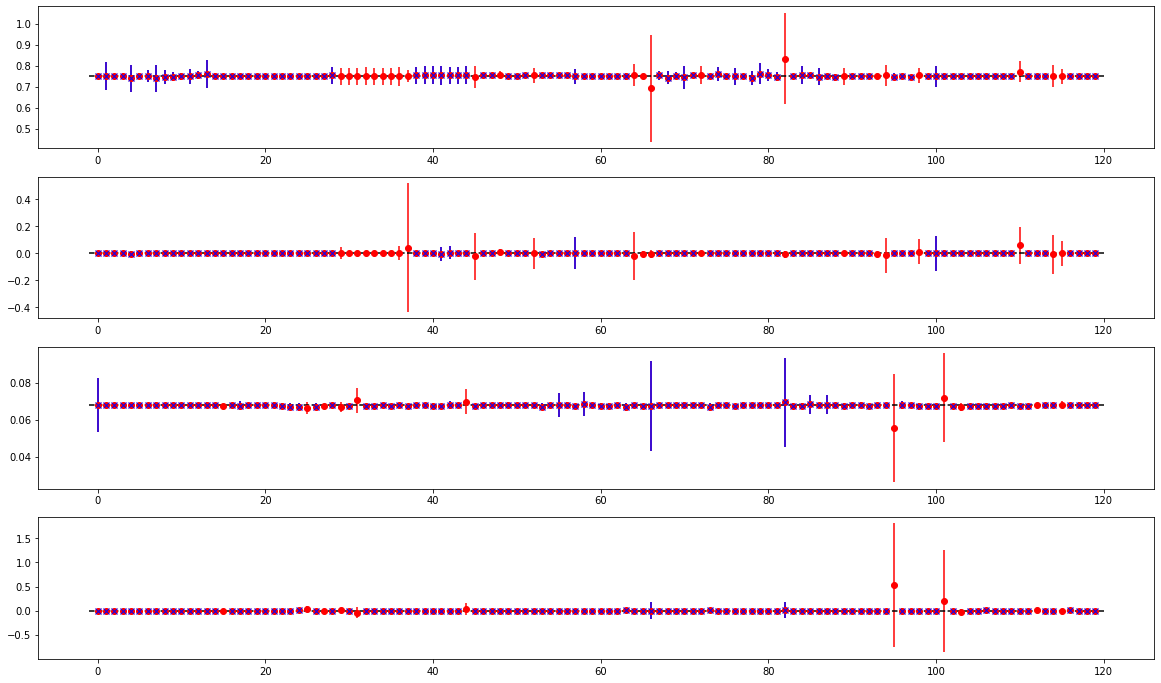

In [48]:
# Plot all combinations (red) and indicate selected (blue) for a selected location
# Note, 'HEAD' and 'TAIL' locations should not be used
# Change probe value

probe = 28

index = torch.arange(max(twiss.limit)*(2*max(twiss.limit) - 1), device=device)

bx, sigma_bx = twiss.data_phase['bx'][probe], twiss.data_phase['sigma_bx'][probe]
ax, sigma_ax = twiss.data_phase['ax'][probe], twiss.data_phase['sigma_ax'][probe]

by, sigma_by = twiss.data_phase['by'][probe], twiss.data_phase['sigma_by'][probe]
ay, sigma_ay = twiss.data_phase['ay'][probe], twiss.data_phase['sigma_ay'][probe]

plt.figure(figsize=(20, 3*4))

# bx
ax1 = plt.subplot(411)
ax1.errorbar(index.cpu().numpy(), bx.cpu().numpy(), yerr=sigma_bx.cpu().numpy(), fmt=' ', color='red', marker='o')
ax1.errorbar(index[mask_x[probe]].cpu().numpy(), bx[mask_x[probe]].cpu().numpy(), yerr=sigma_bx[mask_x[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax1.hlines(model.bx[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

# ax
ax2 = plt.subplot(412)
ax2.errorbar(index.cpu().numpy(), ax.cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', color='red', marker='o')
ax2.errorbar(index[mask_x[probe]].cpu().numpy(), ax[mask_x[probe]].cpu().numpy(), yerr=sigma_ax[mask_x[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax2.hlines(model.ax[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

# by
ax3 = plt.subplot(413)
ax3.errorbar(index.cpu().numpy(), by.cpu().numpy(), yerr=sigma_by.cpu().numpy(), fmt=' ', color='red', marker='o')
ax3.errorbar(index[mask_y[probe]].cpu().numpy(), by[mask_y[probe]].cpu().numpy(), yerr=sigma_by[mask_y[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax3.hlines(model.by[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

# ay
ax4 = plt.subplot(414)
ax4.errorbar(index.cpu().numpy(), ay.cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', color='red', marker='o')
ax4.errorbar(index[mask_y[probe]].cpu().numpy(), ay[mask_y[probe]].cpu().numpy(), yerr=sigma_ay[mask_y[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax4.hlines(model.ay[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

plt.show()

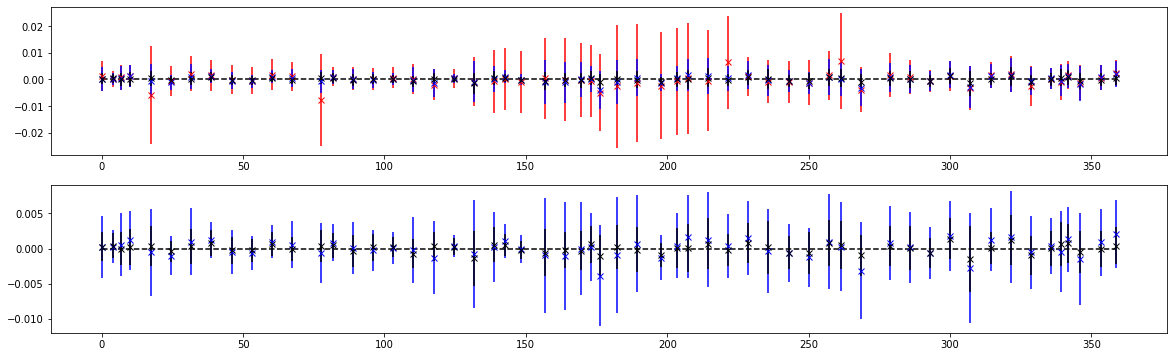

(bx_m - bx_1)[1:-1].abs().sum().item()= 0.951921585
(bx_m - bx_2)[1:-1].abs().sum().item()= 0.580771795
(bx_m - bx_3)[1:-1].abs().sum().item()= 0.237414248



In [49]:
# Twiss data processing can be performed with process_twiss method
# This method returns the result as a dictionary
# dict_keys(['value_a', 'sigma_a', 'error_a', 'value_b', 'sigma_b', 'error_b'])
# And updates self.ax, self.bx, self.ay, self.by and corresponding errors
# Processing is done for one plane ('x' or 'y') at a time

# This method uses weighted estimator for center and spread
# If weight is True, estimated errors for each combinations are used as weights
# If mask is provided, it is used as weights (weight is False) or weights are multiplied by given mask (weight is True)
# Combinations with False values thus have zero weight

# Compare different processing options

# No filtering or weights

out1 = twiss.process_twiss(plane='x', mask=None, weight=False)

# Filter mask is used as weights

out2 = twiss.process_twiss(plane='x', mask=mask_x, weight=False)

# Weights for each combitations are multiplied by filter mask

out3 = twiss.process_twiss(plane='x', mask=mask_x, weight=True)

bx_m = twiss.model.bx

bx_1, sigma_bx_1 = out1['value_b'], out1['sigma_b']
bx_2, sigma_bx_2 = out2['value_b'], out2['sigma_b']
bx_3, sigma_bx_3 = out3['value_b'], out3['sigma_b']

# red - 1, blue - 2, black - 3

plt.figure(figsize=(20, 3*2))

# 1 & 2 & 3
ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_1)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_1/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='red')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_2)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_2/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_3)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_3/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')
ax1.hlines(0, twiss.model.time[1:-1].cpu().numpy().min(), twiss.model.time[1:-1].cpu().numpy().max(), color='black', linestyles='dashed')

# 2 & 3
ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_2)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_2/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_3)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_3/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')
ax2.hlines(0, twiss.model.time[1:-1].cpu().numpy().min(), twiss.model.time[1:-1].cpu().numpy().max(), color='black', linestyles='dashed')

plt.show()

print(f'{(bx_m - bx_1)[1:-1].abs().sum().item()=:12.9}')
print(f'{(bx_m - bx_2)[1:-1].abs().sum().item()=:12.9}')
print(f'{(bx_m - bx_3)[1:-1].abs().sum().item()=:12.9}')
print()

In [50]:
# Compare different cases of twiss computation

# 1 -- from amplitude
# 2 -- from phase (range limit)
# 3 -- from phase (range limit & correction)

twiss = Twiss(model, table, limit=8)
twiss.phase_virtual()
twiss.phase_correct(use_probe=True)

# Uncorrected 

twiss.get_twiss_from_phase()
mask_x = twiss.filter_twiss(plane='x')
mask_y = twiss.filter_twiss(plane='y')
_ = twiss.process_twiss(plane='x', mask=mask_x, weight=True)
_ = twiss.process_twiss(plane='y', mask=mask_y, weight=True)

ax_f_combo, sigma_ax_f_combo = torch.clone(twiss.ax), torch.clone(twiss.sigma_ax)
bx_f_combo, sigma_bx_f_combo = torch.clone(twiss.bx), torch.clone(twiss.sigma_bx)
ay_f_combo, sigma_ay_f_combo = torch.clone(twiss.ay), torch.clone(twiss.sigma_ay)
by_f_combo, sigma_by_f_combo = torch.clone(twiss.by), torch.clone(twiss.sigma_by)

# Corrected

twiss.get_twiss_from_phase(use_correct=True)
mask_x = twiss.filter_twiss(plane='x')
mask_y = twiss.filter_twiss(plane='y')
_ = twiss.process_twiss(plane='x', mask=mask_x, weight=True)
_ = twiss.process_twiss(plane='y', mask=mask_y, weight=True)

ax_f_correct, sigma_ax_f_correct = torch.clone(twiss.ax), torch.clone(twiss.sigma_ax)
bx_f_correct, sigma_bx_f_correct = torch.clone(twiss.bx), torch.clone(twiss.sigma_bx)
ay_f_correct, sigma_ay_f_correct = torch.clone(twiss.ay), torch.clone(twiss.sigma_ay)
by_f_correct, sigma_by_f_correct = torch.clone(twiss.by), torch.clone(twiss.sigma_by)

(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()= 0.673342018
(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=  1.18921539

(bx_m - bx_f)[1:-1].abs().sum().item()=  1.95542662
(by_m - by_f)[1:-1].abs().sum().item()=  1.93087263

(bx_m - bx_f_combo)[1:-1].abs().sum().item()= 0.237414248
(by_m - by_f_combo)[1:-1].abs().sum().item()= 0.344717022

(bx_m - bx_f_correct)[1:-1].abs().sum().item()=0.0208597908
(by_m - by_f_correct)[1:-1].abs().sum().item()=0.0396009748



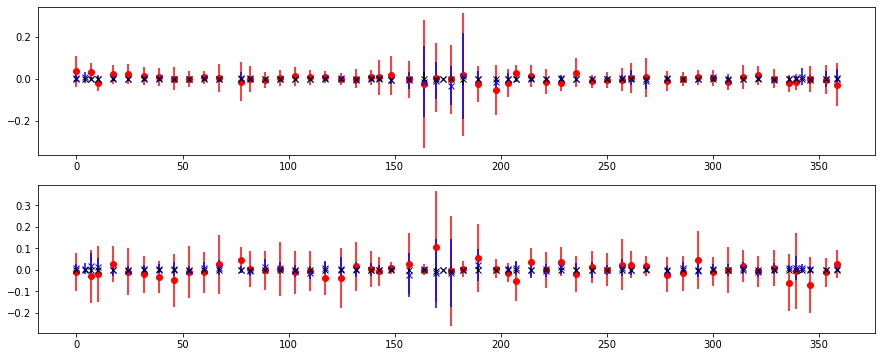

In [51]:
# Plot twiss beta results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

bx_m, by_m = twiss.model.bx, twiss.model.by

print(f'{(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()=:12.9}')
print(f'{(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f_combo)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f_combo)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f_correct)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f_correct)[1:-1].abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m[twiss.model.monitor_index] - bx_a).cpu().numpy(), yerr=sigma_bx_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (bx_m - bx_f_combo)[1:-1].cpu().numpy(), yerr=sigma_bx_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (bx_m - bx_f_correct)[1:-1].cpu().numpy(), yerr=sigma_bx_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m[twiss.model.monitor_index] - by_a).cpu().numpy(), yerr=sigma_by_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (by_m - by_f_combo)[1:-1].cpu().numpy(), yerr=sigma_by_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (by_m - by_f_correct)[1:-1].cpu().numpy(), yerr=sigma_by_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

plt.show()

(ax_m - ax_f)[1:-1].abs().sum().item()=  0.61124298
(ay_m - ay_f)[1:-1].abs().sum().item()= 0.381010717

(ax_m - ax_f_combo)[1:-1].abs().sum().item()=  0.09589584
(ay_m - ay_f_combo)[1:-1].abs().sum().item()=0.0909992138

(ax_m - ax_f_correct)[1:-1].abs().sum().item()=0.00800835444
(ay_m - ay_f_correct)[1:-1].abs().sum().item()=0.0114314721



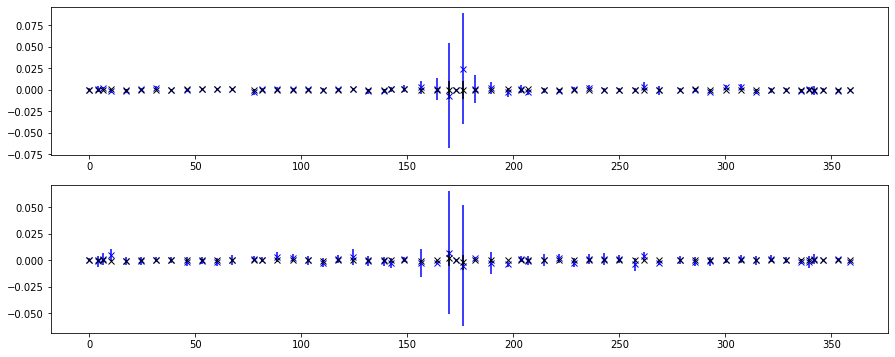

In [52]:
# Plot twiss alpha results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

ax_m, ay_m = twiss.model.ax, twiss.model.ay

print(f'{(ax_m - ax_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(ax_m - ax_f_combo)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f_combo)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(ax_m - ax_f_correct)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f_correct)[1:-1].abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ax_m - ax_f_combo)[1:-1].cpu().numpy(), yerr=sigma_ax_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ax_m - ax_f_correct)[1:-1].cpu().numpy(), yerr=sigma_ax_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ay_m - ay_f_combo)[1:-1].cpu().numpy(), yerr=sigma_ay_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ay_m - ay_f_correct)[1:-1].cpu().numpy(), yerr=sigma_ay_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

plt.show()

In [53]:
# Using several combinations can significanty impove twiss estimation accuracy based on phase data
# In this example random noise is the only error source
# Since signals are generated using the model, phase correction improves accuracy significantly in this case

# Example-05: Default twiss (__call__ method)

In [54]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [55]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

In [56]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

nux= 0.536883083, sigma_nux=7.36653966e-07, error_nux=1.59058251e-08

(ax - ref_ax).abs().sum().item()=8.49003042e-05

(fx - ref_fx).abs().sum().item()=0.0333389076



In [57]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

nuy= 0.576774613, sigma_nuy=1.06597802e-06, error_nuy=2.06825035e-08

(ay - ref_ay).abs().sum().item()=0.000103826671

(fy - ref_fy).abs().sum().item()=0.0538964181



In [58]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

In [59]:
# Default twiss (compute action, beta from amplitude, virtual phase, corrected phase and twiss from phase)

twiss = Twiss(model, table, limit=8)
twiss()

,name,kind,flag,time,ax,sigma_ax,bx,sigma_bx,fx,sigma_fx,ay,sigma_ay,by,sigma_by,fy,sigma_fy
0,HEAD,VIRTUAL,0,0.000000,-0.679265,0.001943,7.472903,0.017284,0.596007,0.000927,0.654110,0.003101,15.864360,0.040862,-0.579298,0.001044
1,STP2,MONITOR,1,0.000000,-0.680146,0.002269,7.472456,0.019481,0.596637,0.004466,0.655609,0.002838,15.858982,0.040085,-0.580147,0.004989
2,IV4P,VIRTUAL,0,4.153500,1.956530,0.003527,14.252304,0.028686,0.981789,0.000796,-2.758845,0.007093,13.852554,0.034952,-0.275536,0.001049
3,STP4,MONITOR,1,6.667000,0.384011,0.001434,3.122324,0.007725,1.432202,0.004750,3.092352,0.006932,30.422085,0.070670,-0.172640,0.004982
4,SRP1,MONITOR,1,10.190565,-0.801957,0.001610,4.733037,0.010109,2.561814,0.004515,1.840634,0.003248,13.253767,0.024326,0.001980,0.005095
5,SRP2,MONITOR,1,17.337624,-0.722081,0.001779,4.565196,0.008966,-2.622237,0.004394,1.838460,0.006932,13.290688,0.054566,0.797086,0.005164
6,SRP3,MONITOR,1,24.484683,-0.766398,0.002152,4.479474,0.011669,-1.467550,0.004540,1.850254,0.007959,13.319626,0.055994,1.585704,0.004943
7,SRP4,MONITOR,1,31.631742,-0.787993,0.001491,4.755943,0.010033,-0.354090,0.004534,1.845284,0.006926,13.295819,0.046320,2.378359,0.005025
8,SRP5,MONITOR,1,38.778801,-0.716370,0.001781,4.494553,0.008653,0.756959,0.004588,1.839972,0.005132,13.255175,0.039048,-3.111807,0.004970
9,SRP6,MONITOR,1,45.925860,-0.789487,0.001707,4.548917,0.010309,1.914824,0.004469,1.837511,0.007907,13.296002,0.061382,-2.315948,0.005117


In [60]:
# Get twiss parameter by index/name

print(twiss.get_ax(28))
print(twiss.get_ax('IP'))

tensor([1.401465562425e-04, 7.007884208660e-04], dtype=torch.float64)
tensor([1.401465562425e-04, 7.007884208660e-04], dtype=torch.float64)


In [61]:
# Get all twiss parameters by index/name

for key, value in twiss.get_twiss(28).items():
    print(f'{key:12.9}: {value.item():12.9}')
else:
    print()
    
for key, value in twiss.get_twiss('IP').items():
    print(f'{key:12.9}: {value.item():12.9}')
else:
    print()

ax          : 0.000140146556
sigma_ax    : 0.000700788421
bx          :  0.750536961
sigma_bx    : 0.00190611105
fx          :   1.02042384
sigma_fx    : 0.000789432625
ay          : 0.000247560272
sigma_ay    : 0.00153985532
by          : 0.0677319493
sigma_by    : 0.000254559627
fy          :    3.1001836
sigma_fy    : 0.00162821003

ax          : 0.000140146556
sigma_ax    : 0.000700788421
bx          :  0.750536961
sigma_bx    : 0.00190611105
fx          :   1.02042384
sigma_fx    : 0.000789432625
ay          : 0.000247560272
sigma_ay    : 0.00153985532
by          : 0.0677319493
sigma_by    : 0.000254559627
fy          :    3.1001836
sigma_fy    : 0.00162821003



# Example-06: Twiss from phase data (precomputed model & weight mask)

In [62]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [63]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

In [64]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

nux= 0.536883021, sigma_nux=5.38372217e-07, error_nux=7.81884664e-08

(ax - ref_ax).abs().sum().item()=9.84985335e-05

(fx - ref_fx).abs().sum().item()=0.0381027471



In [65]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

nuy= 0.576774607, sigma_nuy=7.04754066e-07, error_nuy=2.66486093e-08

(ay - ref_ay).abs().sum().item()=9.2866745e-05

(fy - ref_fy).abs().sum().item()=0.0419811191



In [66]:
# Set model & table
# If limit is passed, model phase advance data is computed

model = Model(path='../config.yaml', limit=8, dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

In [67]:
# Set twiss
# Keep combinations with distance 2, 3 and 4
# Note, with get_twiss_from_phase(use_model=True), precomputed model phase advance is used

twiss = Twiss(model, table, limit=(1, 4), use_model=True)
print(model.combo.shape)
print(twiss.combo.shape)

torch.Size([59, 120, 2, 2])
torch.Size([59, 27, 2, 2])


In [68]:
# Set twiss with external flags
# External flags can be used to mark monitors with anomalies
# If flag is passed, mask for all combinations is generated with zero weight for combinations having marked locations as other
# This mask can be used for twiss processing

flag = torch.clone(model.flag)
flag[10] = 0

twiss = Twiss(model, table, limit=1, use_model=True, flag=flag)
print(twiss.mask.shape)

# Print removed combinations

print((twiss.combo.flatten(1)[twiss.mask.flatten().logical_not()]).reshape(-1, 2, 2))

torch.Size([59, 1])
tensor([[[ 9,  8],
         [ 9, 10]],

        [[11, 10],
         [11, 12]]])


In [69]:
# This mask can be generated with mask_location method

mask = twiss.mask_location([10])
print(mask.shape)

# Print removed combinations

print((twiss.combo.flatten(1)[mask.flatten().logical_not()]).reshape(-1, 2, 2))

torch.Size([59, 1])
tensor([[[ 9,  8],
         [ 9, 10]],

        [[11, 10],
         [11, 12]]])


In [70]:
# Mask based on limit range

# Set twiss

twiss = Twiss(model, table, limit=2, use_model=True)

# Generate mask with zeros for limit one

mask, *_ = twiss.mask_range((1, 2))
print(mask)

# Generate mask with zeros for limit two

mask, *_ = twiss.mask_range((1, 1))
print(mask)

tensor([0, 1, 1, 1, 1, 1])
tensor([1, 0, 0, 0, 0, 0])


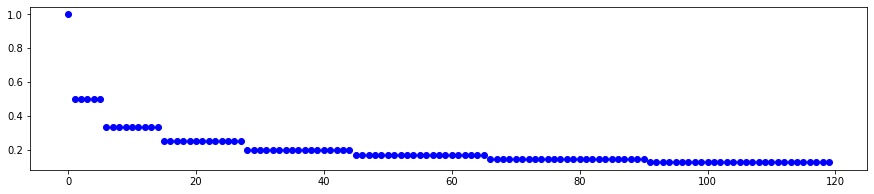

In [71]:
# Mask based on distance

# Set twiss

twiss = Twiss(model, table, limit=8, use_model=True)

# Generate mask

mask, *_ = twiss.mask_distance(lambda x: 1/x)

# Plot weights

plt.figure(figsize=(15, 3))
plt.scatter(range(len(mask)), mask.cpu().numpy(), color='blue')
plt.show()

# Example-07: Bias vs range limit & informed action estimation

In [72]:
# In this example TbT data generated from model with errors is used for twiss inference (without random noise)

# In the case of twiss estimation from phase data, increasing range limit value introduces bias in general
# This bias tends to increase with range limit, but optimal limit might not be equal to one

# In the case of twiss estimation from amplitude data, model twiss is used for action estimation
# If the actual twiss values are off, action estimation is poor and all estimated twiss values are shifted
# Twiss from phase can be used for informed action estimation is this case

In [73]:
# Import correct twiss data at monitor locations

bx_m, ax_m, fx_m, by_m, ay_m, fy_m = numpy.load('../twiss.npy').T

In [74]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../error_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [75]:
# Set near zero noise

noise_x = 1.0E-15*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-15*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.544331291, sigma_nux=5.28138605e-10, error_nux=3.11100035e-11

(ax - ref_ax).abs().sum().item()=4.04579879e-08

(fx - ref_fx).abs().sum().item()=5.38537122e-06



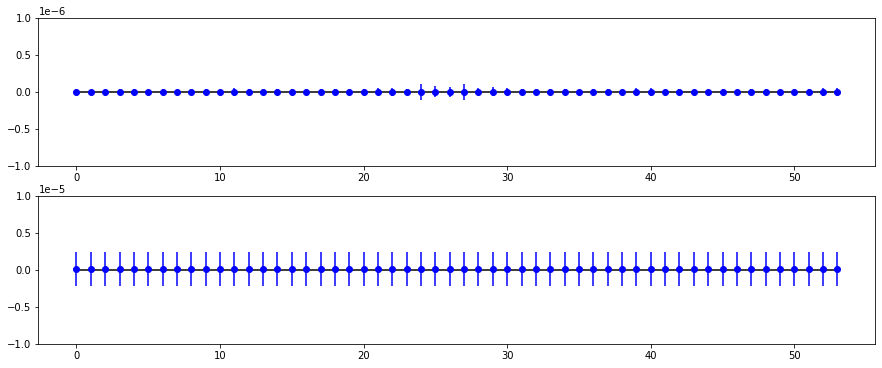

In [76]:
# Compute frequency, amplitude and phase for x plane

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-1.0E-6, +1.0E-6)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-5, +1.0E-5)
plt.show()

nuy= 0.574277342, sigma_nuy=1.42758515e-10, error_nuy=1.42219569e-12

(ay - ref_ay).abs().sum().item()=3.69907646e-10

(fy - ref_fy).abs().sum().item()=2.49145774e-07



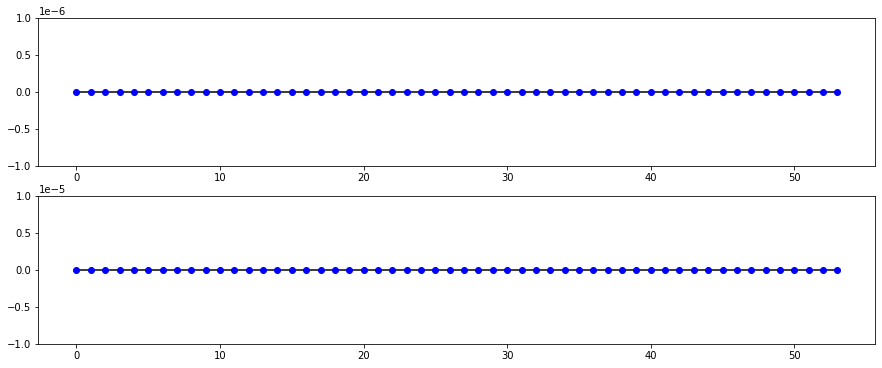

In [77]:
# Compute frequency, amplitude and phase for y plane

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-1.0E-6, +1.0E-6)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-5, +1.0E-5)
plt.show()

In [78]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

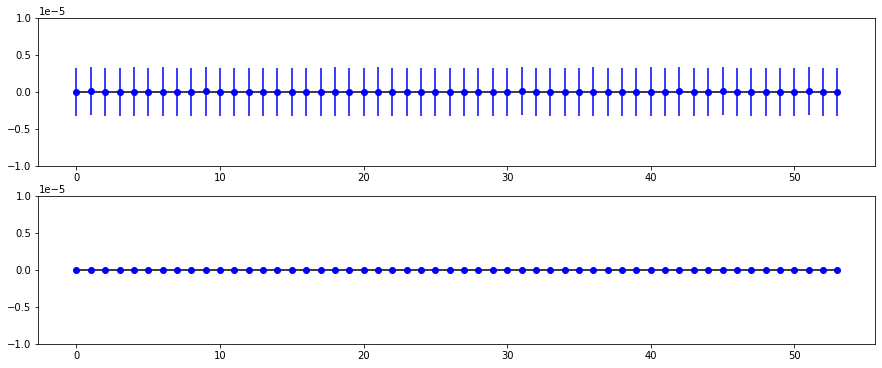

In [79]:
# Compare phase advance between adjacent monitor locations with correct data

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (fx_m - table.phase_x.cpu().numpy()), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-5, +1.0E-5)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (fy_m - table.phase_y.cpu().numpy()), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-5, +1.0E-5)

plt.show()

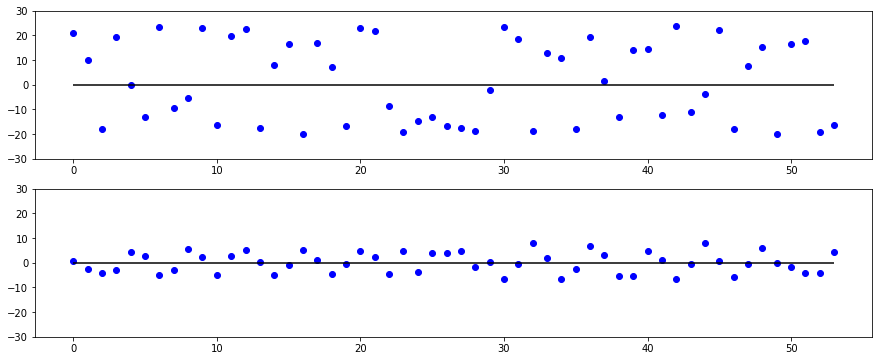

In [80]:
# Compare model twiss with correct twiss

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.scatter(range(model.monitor_count), 100*(bx_m - model.bx[model.monitor_index].cpu().numpy())/model.bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-30, +30)

ax2 = plt.subplot(212)
ax2.scatter(range(model.monitor_count), 100*(by_m - model.by[model.monitor_index].cpu().numpy())/model.by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-30, +30)

plt.show()

In [81]:
# Compute twiss from phase data using different range limit (upto 32)

box = []

for limit in range(1, 32 + 1):

    twiss = Twiss(model, table, limit=limit)

    twiss.phase_virtual()
    twiss.get_twiss_from_phase()
    mask_x = twiss.filter_twiss(plane='x', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': True, 'threshold': 0.5}, sigma={'use': True, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
    mask_y = twiss.filter_twiss(plane='y', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': True, 'threshold': 0.5}, sigma={'use': True, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})

    if twiss.limit != (1, 1):

        twiss.process_twiss(plane='x', mask=mask_x, weight=True)
        twiss.process_twiss(plane='y', mask=mask_y, weight=True)

    else:

        twiss.ax = twiss.data_phase['ax'].flatten()
        twiss.bx = twiss.data_phase['bx'].flatten()
        twiss.ay = twiss.data_phase['ay'].flatten()
        twiss.by = twiss.data_phase['by'].flatten()

        twiss.sigma_ax = twiss.data_phase['sigma_ax'].flatten()
        twiss.sigma_bx = twiss.data_phase['sigma_bx'].flatten()
        twiss.sigma_ay = twiss.data_phase['sigma_ay'].flatten()
        twiss.sigma_by = twiss.data_phase['sigma_by'].flatten()

    bx = twiss.bx[model.monitor_index].cpu().numpy()
    ax = twiss.ax[model.monitor_index].cpu().numpy()
    by = twiss.by[model.monitor_index].cpu().numpy()
    ay = twiss.ay[model.monitor_index].cpu().numpy()

    sigma_bx = twiss.sigma_bx[model.monitor_index].cpu().numpy()
    sigma_ax = twiss.sigma_ax[model.monitor_index].cpu().numpy()
    sigma_by = twiss.sigma_by[model.monitor_index].cpu().numpy()
    sigma_ay = twiss.sigma_ay[model.monitor_index].cpu().numpy()

    box.append(numpy.array([[bx, sigma_bx], [ax, sigma_ax], [by, sigma_by], [ay, sigma_ay]]))
    
    if limit <= 8:
        print(f'limit= {limit}: {"model":>12} {"error":>12}')
        print(f'error_bx: {numpy.abs(model.bx[model.monitor_index].cpu() - bx).sum().item():12.9} {numpy.abs(bx_m - bx).sum().item():12.9}')
        print(f'error_by: {numpy.abs(model.by[model.monitor_index].cpu() - by).sum().item():12.9} {numpy.abs(by_m - by).sum().item():12.9}')
        print(f'error_ax: {numpy.abs(model.ax[model.monitor_index].cpu() - ax).sum().item():12.9} {numpy.abs(ax_m - ax).sum().item():12.9}')
        print(f'error_ay: {numpy.abs(model.ay[model.monitor_index].cpu() - ay).sum().item():12.9} {numpy.abs(ay_m - ay).sum().item():12.9}')
        print()

box = numpy.array(box).T

# As it can be seen, for larger range limit value, bias increases
# Since the effect of noise in this example can be neglected, the discrepancy is only due to the bias
# Still, using limit=1 doesn't provide optimal accuracy
# In this example limit=2 is optimal, for larger values bias is stronger

limit= 1:        model        error
error_bx:   80.5607213   0.99877534
error_by:   29.9780715   3.57418069
error_ax:   18.8607779  0.167695416
error_ay:   5.98873525  0.554359655

limit= 2:        model        error
error_bx:   80.3818974   0.75823522
error_by:   28.9871256   2.10509027
error_ax:   18.8350415  0.196775636
error_ay:   5.79728247  0.309870257

limit= 3:        model        error
error_bx:   78.0111645   3.03535445
error_by:   29.9560544   3.24583719
error_ax:   18.0391362   1.03171095
error_ay:   6.20579977  0.668405111

limit= 4:        model        error
error_bx:   80.7616875    2.5882233
error_by:   30.0436144   3.42576748
error_ax:   19.5905233   1.02936923
error_ay:   6.19283952  0.639229412

limit= 5:        model        error
error_bx:   83.5774287    3.8243391
error_by:    29.552712   3.14764791
error_ax:   19.8261132   1.09533979
error_ay:   5.92945331  0.506254941

limit= 6:        model        error
error_bx:   84.6479793   5.08285314
error_by:   29.7502077 

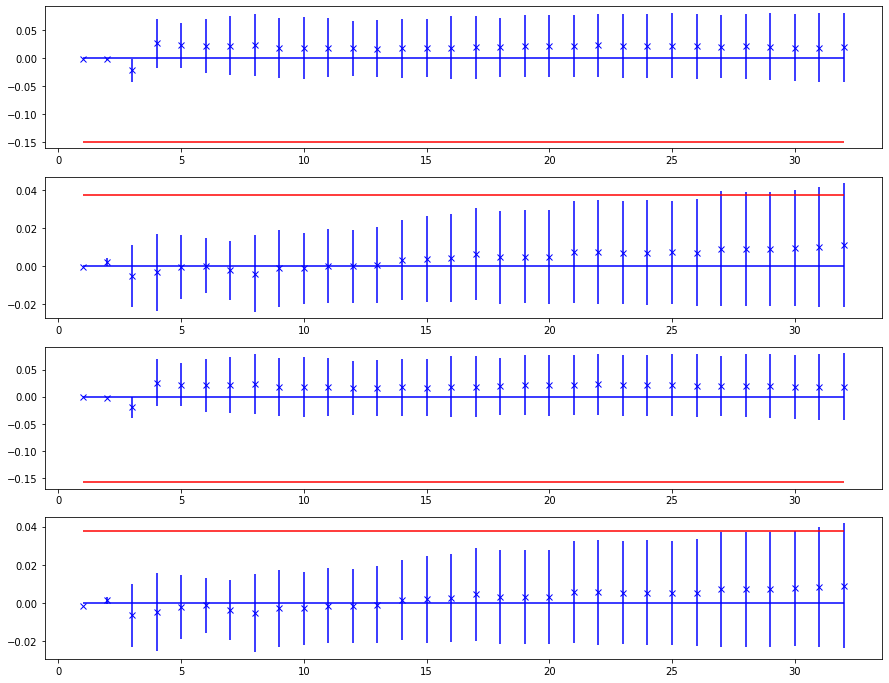

In [82]:
# Examine data for selected location

index = 25
out, sigma_out = box[index]

bx, ax, by, ay = out
sigma_bx, sigma_ax, sigma_by, sigma_ay = sigma_out

plt.figure(figsize=(15, 4*3))

ax1 = plt.subplot(411)
ax1.errorbar(range(1, 1 + len(bx)), (bx_m[index] - bx)/bx_m[index], yerr=sigma_bx/bx_m[index], fmt=' ', marker='x', color='blue')
ax1.hlines(0, 1, len(bx), colors='blue')
ax1.hlines((bx_m[index] - model.bx[model.monitor_index][index].cpu())/bx_m[index], 1, len(bx), colors='red')

ax2 = plt.subplot(412)
ax2.errorbar(range(1, 1 + len(by)), (by_m[index] - by)/by_m[index], yerr=sigma_by/by_m[index], fmt=' ', marker='x', color='blue')
ax2.hlines(0, 1, len(by), colors='blue')
ax2.hlines((by_m[index] - model.by[model.monitor_index][index].cpu())/by_m[index], 1, len(by), colors='red')

ax3 = plt.subplot(413)
ax3.errorbar(range(1, 1 + len(ax)), (ax_m[index] - ax)/ax_m[index], yerr=sigma_ax/ax_m[index], fmt=' ', marker='x', color='blue')
ax3.hlines(0, 1, len(ax), colors='blue')
ax3.hlines((ax_m[index] - model.ax[model.monitor_index][index].cpu())/ax_m[index], 1, len(bx), colors='red')

ax4 = plt.subplot(414)
ax4.errorbar(range(1, 1 + len(ay)), (ay_m[index] - ay)/ay_m[index], yerr=sigma_ay/ay_m[index], fmt=' ', marker='x', color='blue')
ax4.hlines(0, 1, len(ay), colors='blue')
ax4.hlines((ay_m[index] - model.ay[model.monitor_index][index].cpu())/ay_m[index], 1, len(bx), colors='red')

plt.show()

# Note, this bias will decrease for corrected lattice

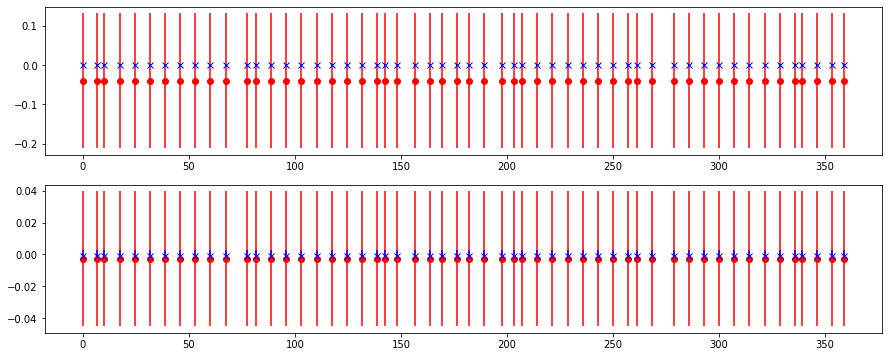

In [83]:
# Compute twiss from amplitude using twiss from phase data for action estimation

# Set twiss instance

twiss = Twiss(model, table, limit=4)


# Compute twiss from phase data
twiss.phase_virtual()
twiss.get_twiss_from_phase()
mask_x = twiss.filter_twiss(plane='x', phase={'use': True, 'threshold': 10.0}, model={'use': False, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
mask_y = twiss.filter_twiss(plane='y', phase={'use': True, 'threshold': 10.0}, model={'use': False, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
twiss.process_twiss(plane='x', mask=mask_x, weight=True)
twiss.process_twiss(plane='y', mask=mask_y, weight=True)


# Twiss from amplitude using model for action estimation

twiss.get_action()
twiss.get_twiss_from_amplitude()
bx_1 = twiss.data_amplitude['bx'].cpu().numpy()
by_1 = twiss.data_amplitude['by'].cpu().numpy()
sigma_bx_1 = twiss.data_amplitude['sigma_bx'].cpu().numpy()
sigma_by_1 = twiss.data_amplitude['sigma_by'].cpu().numpy()

# Twiss from amplitude using twiss from phase for action estimation

twiss.get_action(bx=twiss.bx[model.monitor_index], by=twiss.by[model.monitor_index], sigma_bx=twiss.sigma_bx[model.monitor_index], sigma_by=twiss.sigma_by[model.monitor_index])
twiss.get_twiss_from_amplitude()
bx_2 = twiss.data_amplitude['bx'].cpu().numpy()
by_2 = twiss.data_amplitude['by'].cpu().numpy()
sigma_bx_2 = twiss.data_amplitude['sigma_bx'].cpu().numpy()
sigma_by_2 = twiss.data_amplitude['sigma_by'].cpu().numpy()

# Compare

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m - bx_1)/bx_m, yerr=sigma_bx_1/bx_m, fmt=' ', marker='o', color='red')
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m - bx_2)/bx_m, yerr=sigma_bx_2/bx_m, fmt=' ', marker='x', color='blue')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m - by_1)/by_m, yerr=sigma_by_1/by_m, fmt=' ', marker='o', color='red')
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m - by_2)/by_m, yerr=sigma_by_2/by_m, fmt=' ', marker='x', color='blue')

plt.show()

# Note, bias from action estimation (all values are shifted) is corrected

# Example-08: Twiss from test signals

In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

In [3]:
# This example is similar to the previous one, but test tbt data is generated using Model functions

In [4]:
# Set model

model = Model(path='../config.yaml', dtype=dtype, device=device)

# Compute transport matrices

model.make_transport()

# Generate and apply errors

model.make_kick(1.0E-3, 0.0)
model.apply_error()

# Compute one-turn matrix

model.make_turn()

# Compute twiss (not used in generation of trajectories)

flag = model.make_twiss()
print(flag)

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**12

# Generate trajectories

trajectory =  model.make_trajectory(length, initial)

True


In [5]:
# Set correct twiss data at monitor locations

ax_m, bx_m, ay_m, by_m = torch.stack([model.convert_wolski_cs(model.wolski[i]) for i in model.monitor_index]).T

ax_m, bx_m, ay_m, by_m = ax_m.cpu().numpy(), bx_m.cpu().numpy(), ay_m.cpu().numpy(), by_m.cpu().numpy()

probe = torch.tensor(model.monitor_index)
other = probe.roll(-1, 0)

fx_m, fy_m = model.advance.T

fx_m = fx_m.roll(1, 0).cumsum(-1)
fx_m = fx_m[other] - fx_m[probe]
fx_m[-1] += 2.0*numpy.pi*model.tune[0]

fy_m = fy_m.roll(1, 0).cumsum(-1)
fy_m = fy_m[other] - fy_m[probe]
fy_m[-1] += 2.0*numpy.pi*model.tune[1]

fx_m, fy_m = fx_m.cpu().numpy(), fy_m.cpu().numpy()

In [6]:
# Compute reference parameters (frequency, amplitude and phase)

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, trajectory[model.monitor_index, :, 0])
y = Data.from_data(w, trajectory[model.monitor_index, :, 2])

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [7]:
# Set near zero noise

noise_x = 1.0E-15*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-15*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.553097487, sigma_nux=2.71562151e-10, error_nux=8.34821101e-12

(ax - ref_ax).abs().sum().item()=2.21490741e-08

(fx - ref_fx).abs().sum().item()=1.86447528e-06



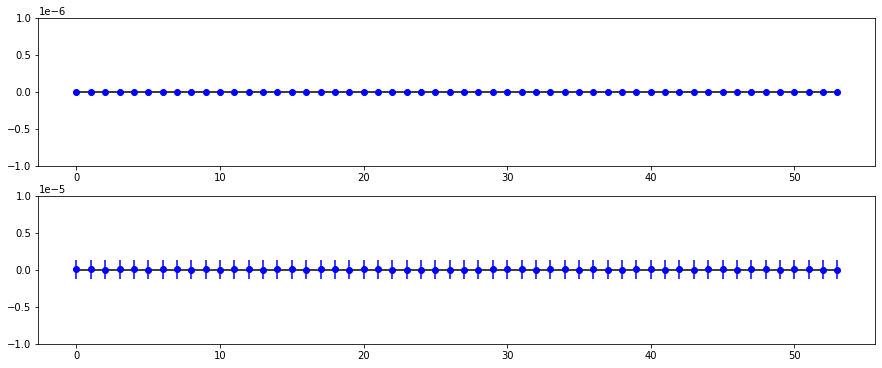

In [8]:
# Compute frequency, amplitude and phase for x plane

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-1.0E-6, +1.0E-6)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-5, +1.0E-5)
plt.show()

nuy= 0.571219434, sigma_nuy=1.55383626e-10, error_nuy=7.54352136e-12

(ay - ref_ay).abs().sum().item()=5.73144312e-09

(fy - ref_fy).abs().sum().item()=1.31482079e-06



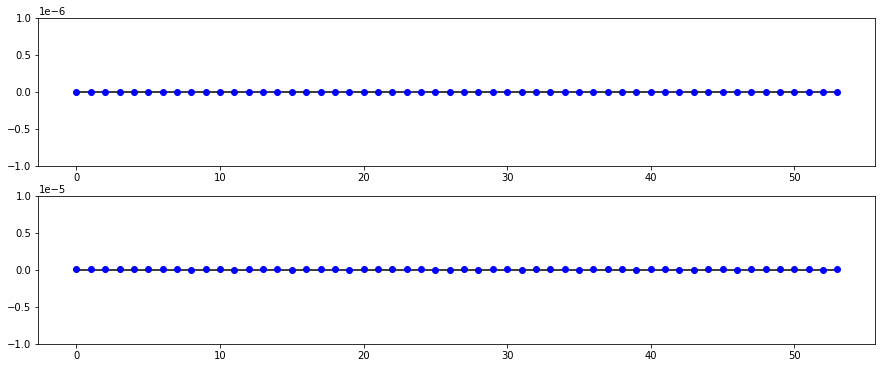

In [9]:
# Compute frequency, amplitude and phase for y plane

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=4, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-1.0E-6, +1.0E-6)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-5, +1.0E-5)
plt.show()

In [10]:
# Set table

table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

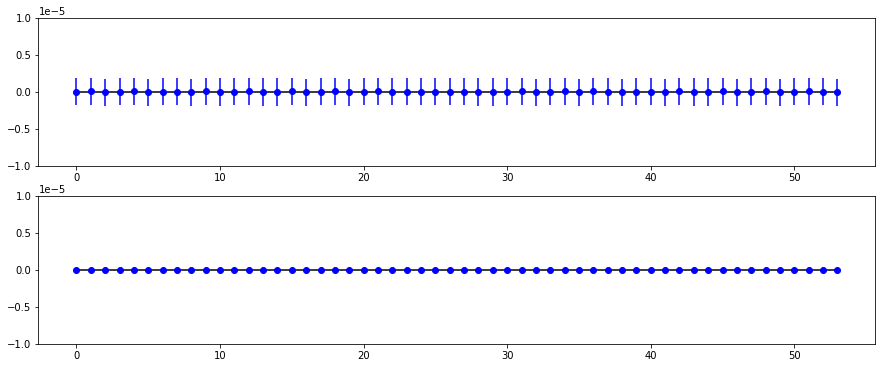

In [11]:
# Compare phase advance between adjacent monitor locations with correct data

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (fx_m - table.phase_x.cpu().numpy()), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-5, +1.0E-5)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (fy_m - table.phase_y.cpu().numpy()), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-5, +1.0E-5)

plt.show()

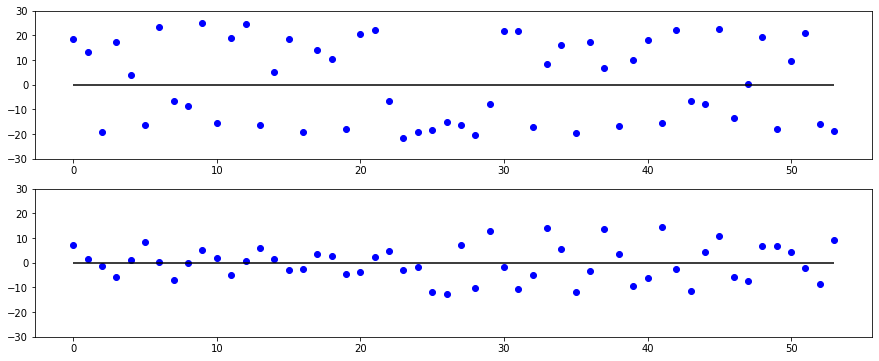

In [12]:
# Compare model twiss with correct twiss

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.scatter(range(model.monitor_count), 100*(bx_m - model.bx[model.monitor_index].cpu().numpy())/model.bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-30, +30)

ax2 = plt.subplot(212)
ax2.scatter(range(model.monitor_count), 100*(by_m - model.by[model.monitor_index].cpu().numpy())/model.by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-30, +30)

plt.show()

In [13]:
# Compute twiss from phase data using different range limit (upto 32)

box = []

for limit in range(1, 32 + 1):

    twiss = Twiss(model, table, limit=limit)

    twiss.phase_virtual()
    twiss.get_twiss_from_phase()
    mask_x = twiss.filter_twiss(plane='x', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': True, 'threshold': 0.5}, sigma={'use': True, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
    mask_y = twiss.filter_twiss(plane='y', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': True, 'threshold': 0.5}, sigma={'use': True, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})

    if twiss.limit != (1, 1):

        twiss.process_twiss(plane='x', mask=mask_x, weight=True)
        twiss.process_twiss(plane='y', mask=mask_y, weight=True)

    else:

        twiss.ax = twiss.data_phase['ax'].flatten()
        twiss.bx = twiss.data_phase['bx'].flatten()
        twiss.ay = twiss.data_phase['ay'].flatten()
        twiss.by = twiss.data_phase['by'].flatten()

        twiss.sigma_ax = twiss.data_phase['sigma_ax'].flatten()
        twiss.sigma_bx = twiss.data_phase['sigma_bx'].flatten()
        twiss.sigma_ay = twiss.data_phase['sigma_ay'].flatten()
        twiss.sigma_by = twiss.data_phase['sigma_by'].flatten()

    bx = twiss.bx[model.monitor_index].cpu().numpy()
    ax = twiss.ax[model.monitor_index].cpu().numpy()
    by = twiss.by[model.monitor_index].cpu().numpy()
    ay = twiss.ay[model.monitor_index].cpu().numpy()

    sigma_bx = twiss.sigma_bx[model.monitor_index].cpu().numpy()
    sigma_ax = twiss.sigma_ax[model.monitor_index].cpu().numpy()
    sigma_by = twiss.sigma_by[model.monitor_index].cpu().numpy()
    sigma_ay = twiss.sigma_ay[model.monitor_index].cpu().numpy()

    box.append(numpy.array([[bx, sigma_bx], [ax, sigma_ax], [by, sigma_by], [ay, sigma_ay]]))
    
    if limit <= 8:
        print(f'limit= {limit}: {"model":>12} {"error":>12}')
        print(f'error_bx: {numpy.abs(model.bx[model.monitor_index].cpu() - bx).sum().item():12.9} {numpy.abs(bx_m - bx).sum().item():12.9}')
        print(f'error_by: {numpy.abs(model.by[model.monitor_index].cpu() - by).sum().item():12.9} {numpy.abs(by_m - by).sum().item():12.9}')
        print(f'error_ax: {numpy.abs(model.ax[model.monitor_index].cpu() - ax).sum().item():12.9} {numpy.abs(ax_m - ax).sum().item():12.9}')
        print(f'error_ay: {numpy.abs(model.ay[model.monitor_index].cpu() - ay).sum().item():12.9} {numpy.abs(ay_m - ay).sum().item():12.9}')
        print()

box = numpy.array(box).T

# As it can be seen, for larger range limit value, bias increases
# Since the effect of noise in this example can be neglected, the discrepancy is only due to the bias
# Still, using limit=1 doesn't provide optimal accuracy
# In this example limit=2 is optimal, for larger values bias is stronger

limit= 1:        model        error
error_bx:   85.5760218   1.87503957
error_by:   64.8252704   12.7481072
error_ax:   19.9556615  0.284152579
error_ay:     14.39982   1.86151671

limit= 2:        model        error
error_bx:   85.1791257   1.71544336
error_by:   56.8410569    4.6437727
error_ax:   19.8981283  0.397100415
error_ay:   13.3499618  0.725204173

limit= 3:        model        error
error_bx:    80.756519   5.52102302
error_by:   56.1584671   5.08831839
error_ax:   18.6552026   1.57654371
error_ay:   13.3770483  0.862583718

limit= 4:        model        error
error_bx:    83.726353   6.31218434
error_by:    56.205983    5.9204779
error_ax:   20.5881168   1.65878363
error_ay:   13.2467624  0.893723274

limit= 5:        model        error
error_bx:   88.8186876   5.33968535
error_by:   56.6968221   6.96093388
error_ax:   20.9375369   1.39030023
error_ay:   13.4597378   1.15623704

limit= 6:        model        error
error_bx:   91.1313067   7.38372015
error_by:   55.6778342 

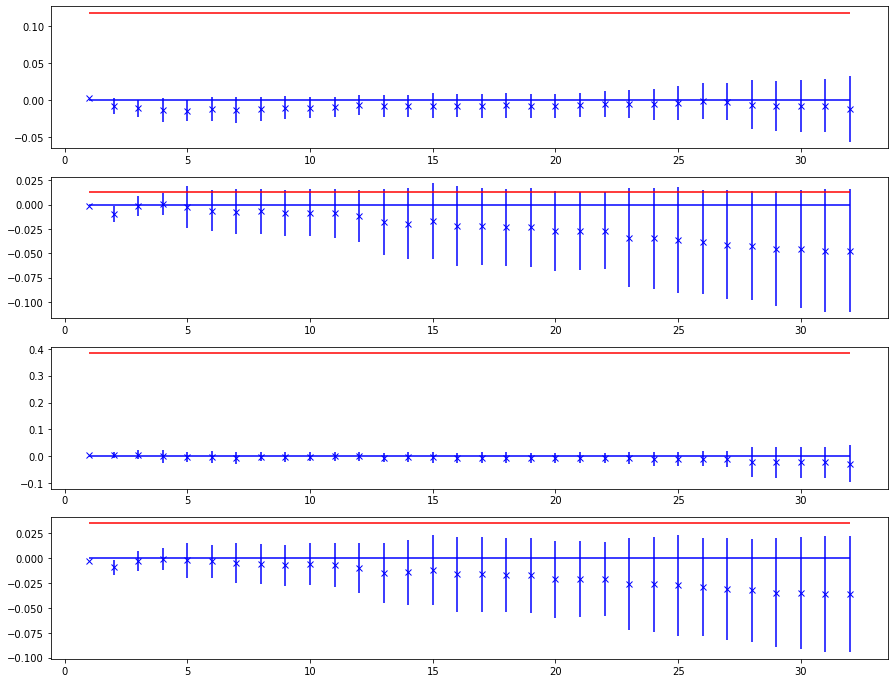

In [14]:
# Examine data for selected location

index = 1
out, sigma_out = box[index]

bx, ax, by, ay = out
sigma_bx, sigma_ax, sigma_by, sigma_ay = sigma_out

plt.figure(figsize=(15, 4*3))

ax1 = plt.subplot(411)
ax1.errorbar(range(1, 1 + len(bx)), (bx_m[index] - bx)/bx_m[index], yerr=sigma_bx/bx_m[index], fmt=' ', marker='x', color='blue')
ax1.hlines(0, 1, len(bx), colors='blue')
ax1.hlines((bx_m[index] - model.bx[model.monitor_index][index].cpu())/bx_m[index], 1, len(bx), colors='red')

ax2 = plt.subplot(412)
ax2.errorbar(range(1, 1 + len(by)), (by_m[index] - by)/by_m[index], yerr=sigma_by/by_m[index], fmt=' ', marker='x', color='blue')
ax2.hlines(0, 1, len(by), colors='blue')
ax2.hlines((by_m[index] - model.by[model.monitor_index][index].cpu())/by_m[index], 1, len(by), colors='red')

ax3 = plt.subplot(413)
ax3.errorbar(range(1, 1 + len(ax)), (ax_m[index] - ax)/ax_m[index], yerr=sigma_ax/ax_m[index], fmt=' ', marker='x', color='blue')
ax3.hlines(0, 1, len(ax), colors='blue')
ax3.hlines((ax_m[index] - model.ax[model.monitor_index][index].cpu())/ax_m[index], 1, len(bx), colors='red')

ax4 = plt.subplot(414)
ax4.errorbar(range(1, 1 + len(ay)), (ay_m[index] - ay)/ay_m[index], yerr=sigma_ay/ay_m[index], fmt=' ', marker='x', color='blue')
ax4.hlines(0, 1, len(ay), colors='blue')
ax4.hlines((ay_m[index] - model.ay[model.monitor_index][index].cpu())/ay_m[index], 1, len(bx), colors='red')

plt.show()

# Note, this bias will decrease for corrected lattice

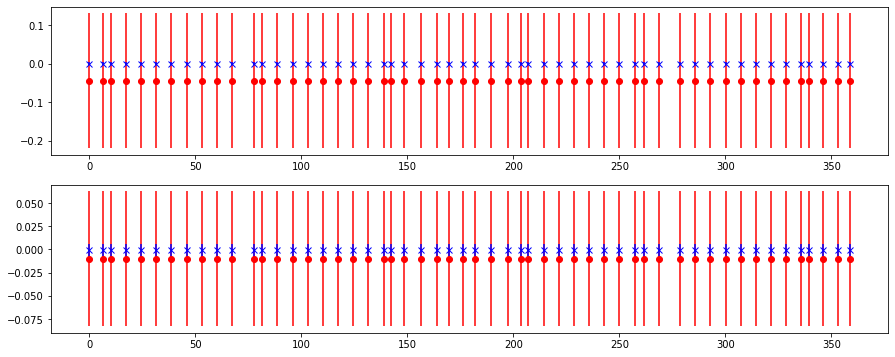

In [15]:
# Compute twiss from amplitude using twiss from phase data for action estimation

# Set twiss instance

twiss = Twiss(model, table, limit=4)


# Compute twiss from phase data
twiss.phase_virtual()
twiss.get_twiss_from_phase()
mask_x = twiss.filter_twiss(plane='x', phase={'use': True, 'threshold': 10.0}, model={'use': False, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
mask_y = twiss.filter_twiss(plane='y', phase={'use': True, 'threshold': 10.0}, model={'use': False, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
twiss.process_twiss(plane='x', mask=mask_x, weight=True)
twiss.process_twiss(plane='y', mask=mask_y, weight=True)


# Twiss from amplitude using model for action estimation

twiss.get_action()
twiss.get_twiss_from_amplitude()
bx_1 = twiss.data_amplitude['bx'].cpu().numpy()
by_1 = twiss.data_amplitude['by'].cpu().numpy()
sigma_bx_1 = twiss.data_amplitude['sigma_bx'].cpu().numpy()
sigma_by_1 = twiss.data_amplitude['sigma_by'].cpu().numpy()

# Twiss from amplitude using twiss from phase for action estimation

twiss.get_action(bx=twiss.bx[model.monitor_index], by=twiss.by[model.monitor_index], sigma_bx=twiss.sigma_bx[model.monitor_index], sigma_by=twiss.sigma_by[model.monitor_index])
twiss.get_twiss_from_amplitude()
bx_2 = twiss.data_amplitude['bx'].cpu().numpy()
by_2 = twiss.data_amplitude['by'].cpu().numpy()
sigma_bx_2 = twiss.data_amplitude['sigma_bx'].cpu().numpy()
sigma_by_2 = twiss.data_amplitude['sigma_by'].cpu().numpy()

# Compare

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m - bx_1)/bx_m, yerr=sigma_bx_1/bx_m, fmt=' ', marker='o', color='red')
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m - bx_2)/bx_m, yerr=sigma_bx_2/bx_m, fmt=' ', marker='x', color='blue')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m - by_1)/by_m, yerr=sigma_by_1/by_m, fmt=' ', marker='o', color='red')
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m - by_2)/by_m, yerr=sigma_by_2/by_m, fmt=' ', marker='x', color='blue')

plt.show()

# Note, bias from action estimation (all values are shifted) is corrected